<a href="https://colab.research.google.com/github/m4gaikwad/Text_Classification_LSTM/blob/main/Simple_LSTM_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NLTK and SpaCy Libraries

In [1]:
# NLP
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import spacy
!pip install contractions
import contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.1 MB/s eta 0:00:00


In [2]:
nltk.download("all")
!python -m spacy download en_core_web_sm

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

2023-08-14 10:06:02.430277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 15.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#Import Tensorflow Libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical

#Import Other Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Get Data

In [5]:
data = pd.read_csv("/content/drive/MyDrive/NLP_IIT_Session/ecommerceDataset.csv",names=['Labels','Description'])
data.head()

,Labels,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


#Text Pre-processing


In [6]:
len(data)

50425

In [7]:
data.dropna(inplace = True)
data.drop_duplicates(inplace = True)
data.reset_index(drop = True, inplace = True)

In [8]:
len(data)

27802

#Text Cleaning

In [9]:
#Regular Expression
regexp = RegexpTokenizer("[\w']+")

In [10]:
#Lowercase
def text_lower(text):
  text = text.lower()
  return text

In [11]:
#Remove Whitespace
def remove_whitespace(text):
  text = text.strip()
  return text

In [12]:
#Remove Punctuation
def remove_punctuation(text):
  punct = string.punctuation
  punct = punct.replace("'","")
  text = text.translate(str.maketrans("", "",punct))
  return text

In [13]:
#Remove HTML
def remove_html(text):
  html = re.compile(r'<.*?>')
  text = html.sub(r'',text)
  return text

In [14]:
# Removing emojis
def remove_emoji(text):
  emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+",flags=re.UNICODE
  )
  text = emoji_pattern.sub(r'',text)
  return text

In [15]:
#Remove URLS
def remove_http_links(text):
  text = re.sub('http://\S+|https://\S+','',text)
  return text

In [16]:
#Convert Abbreviated Words
abbrev = pd.read_csv('/content/drive/MyDrive/NLP_IIT_Session/abbrevations.csv',names=['SMF','FF'])
abbrev.head()

,SMF,FF
0,?,I have a question
1,?,I don’t understand what you mean
2,?4U,I have a question for you
3,;S,GeHmm? What did you say?
4,^^,read message


In [17]:
abbrev_lower = pd.DataFrame()
abbrev_lower['SMF'] = abbrev['SMF'].apply(text_lower)
abbrev_lower['FF'] = abbrev['FF'].apply(text_lower)
abbrev_dict = dict(zip(list(abbrev_lower.SMF), list(abbrev_lower.FF)))
abbrev_words = list(abbrev_dict.keys())

In [18]:
def convert_abbrev(text):
  words = []
  for word in regexp.tokenize(text):
    if word in abbrev_words:
      words = words + abbrev_dict[word].split()
    else:
      words = words + word.split()

  text_converted = " ".join(words)

  return text_converted

In [19]:
#Convert Contractions like you're
def convert_contractions(text):
  text = contractions.fix(text)
  return text

In [20]:
#Remove Stopwords
def remove_stopwords(text):
  text = " ".join([word for word in nltk.tokenize.word_tokenize(text) if word not in stopwords.words('english')])
  return text

In [21]:
#Lemmatization

# Lemmatization
nlp = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])

def lemmatize(text):
  text = " ".join([token.lemma_ for token in nlp(text)])
  return text

In [22]:
#Remove Non-Alphabetic Characters
def discard_non_alpha(text):
  word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
  text = " ".join(word_list_non_alpha)
  return text

In [23]:
#Aggregating All definitions

def text_clean(text):
  text = text_lower(text)
  text = remove_whitespace(text)
  text = re.sub('\n' , '', text)
  text = re.sub('\[.*?\]', '', text)
  text = remove_http_links(text)
  text = remove_punctuation(text)
  text = remove_html(text)
  text = remove_emoji(text)
  text = convert_abbrev(text)
  text = convert_contractions(text)
  text = remove_stopwords(text)
  text = discard_non_alpha(text)
  text = lemmatize(text)

  return text

In [24]:
# Apply on Dataset
data['Description_Clean'] = data['Description'].apply(text_clean)
data.head()

,Labels,Description,Description_Clean
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design frame wall hang motivationa...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf frame paint wood inch kiss inch special ef...
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf texture modern art print frame paint synth...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print frame paint synthetic inch ki...
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gift india wooden happy birthday un...


#Label Encoding

In [25]:
le = LabelEncoder()
data['Encoded_Labels'] = le.fit_transform(data['Labels'])
#label = data['Encoded_Labels'].unique()
inv_labels = le.inverse_transform([0,1,2,3])
label_len = len(le.classes_)
data.head()

,Labels,Description,Description_Clean,Encoded_Labels
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design frame wall hang motivationa...,3
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf frame paint wood inch kiss inch special ef...,3
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf texture modern art print frame paint synth...,3
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print frame paint synthetic inch ki...,3
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gift india wooden happy birthday un...,3


#Data Splitting

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data.Description_Clean,data.Encoded_Labels,stratify=data.Encoded_Labels,random_state=2)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train,dtype=np.float32)
y_test = np.array(y_test,dtype=np.float32)

#Processing Data for DL

In [27]:
batch_size = 64
max_words = 10000
max_len = 200
embedding_dim = 100
lstm_units = 64

In [28]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
seqs = tok.texts_to_sequences(X_train)
test_seqs = tok.texts_to_sequences(X_test)
seq_matrix = sequence.pad_sequences(seqs,max_len)
test_seq_matrix = sequence.pad_sequences(test_seqs,max_len)

In [29]:
seq_matrix[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0, 2769, 5023, 1062,
        543, 2667,   48,   16,  247,   22,  754,   

#LSTM INPUT

**batch_size:** The number of sequences you feed into the model at once. It's a hyperparameter that you specify when training and represents the number of samples that are processed in parallel during each training iteration. For example, if your batch size is 32, then you'll process 32 sequences at a time.

**sequence_length:** The length of each input sequence. This value is determined by the padding you applied to make all sequences the same length. If your maximum sequence length is, for instance, 50 (meaning all sequences are padded/truncated to 50 tokens), then sequence_length would be 50.

**embedding_dim:** The dimensionality of the word embeddings used to represent each token in the sequence. This is the length of the dense vectors used to represent words. It's a hyperparameter that you set based on your problem and the size of your dataset. For instance, you might choose an embedding_dim of 100 or 300

#LSTM Model

In [30]:
def LSTM_Model(words,len,dim,units,num_labels):
  model = tf.keras.Sequential()
  model.add(Embedding(input_dim=words, output_dim=dim, input_length=len))
  model.add(LSTM(units=units, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(num_labels, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [31]:
model = LSTM_Model(max_words,max_len,embedding_dim,lstm_units,label_len)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 1,042,500
Trainable params: 1,042,500
Non-trainable params: 0
_________________________________________________________________


#Train Model

In [33]:
model.fit(seq_matrix,y_train,epochs=3,batch_size=batch_size,validation_split=0.2)

Epoch 1/3
261/261 [==============================] - 142s 526ms/step - loss: 0.5484 - accuracy: 0.8083 - val_loss: 0.2721 - val_accuracy: 0.9326
Epoch 2/3
261/261 [==============================] - 144s 551ms/step - loss: 0.1978 - accuracy: 0.9531 - val_loss: 0.2349 - val_accuracy: 0.9427
Epoch 3/3
261/261 [==============================] - 137s 527ms/step - loss: 0.1630 - accuracy: 0.9600 - val_loss: 0.2510 - val_accuracy: 0.9410


#Test Model

In [34]:
prediction = model.predict(test_seq_matrix)

218/218 [==============================] - 10s 46ms/step


In [36]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test,np.argmax(prediction,axis=1),target_names=inv_labels))

                        precision    recall  f1-score   support

             Household       0.95      0.92      0.93      1564
                 Books       0.96      0.97      0.96      1419
Clothing & Accessories       0.92      0.91      0.92      1327
           Electronics       0.93      0.96      0.94      2641

              accuracy                           0.94      6951
             macro avg       0.94      0.94      0.94      6951
          weighted avg       0.94      0.94      0.94      6951



<Axes: >

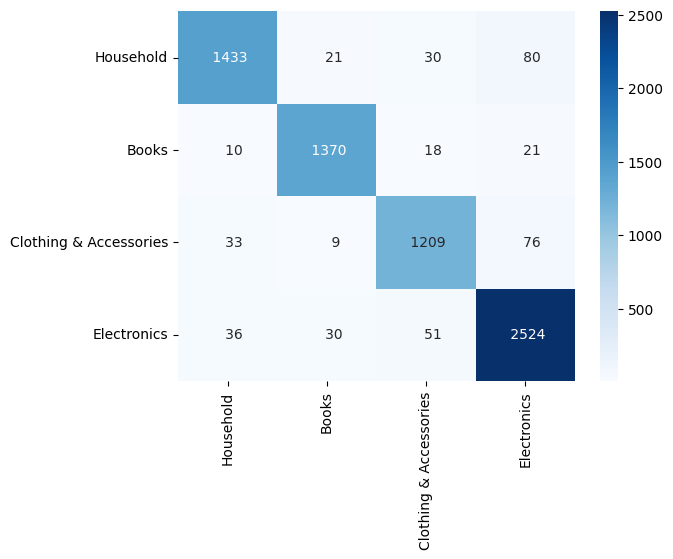

In [39]:
sns.heatmap(confusion_matrix(y_test,np.argmax(prediction,axis=1)),annot=True,fmt='5',cmap='Blues',xticklabels=inv_labels,yticklabels=inv_labels)